In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import unidecode
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999


import time
import unicodedata

import datetime
from datetime import timedelta, datetime

import csv
import os

import sys
sys.path.append('./lib/')
from functions import *

from tqdm import tnrange, tqdm_notebook
from unidecode import unidecode

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import glob

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

import locale
locale.setlocale(locale.LC_ALL, 'es_ES')

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Import data

In [3]:
period = '20180210-3'

In [4]:
df = pd.read_csv('../data/output/03_scraped_data_clean_third_{}.csv'.format(period), 
                 sep='|', quoting=1, encoding='utf-8', low_memory=False)

In [5]:
df.shape

(1943782, 27)

# Expanding Salary over time

## Define ID for person 

In [6]:
df['person'] = df['givenn'].fillna('-1') + ' ' + df['lastn'].fillna('-1') + ' ' + df['lastn2'].fillna('-1')
df['person'] = df['person'].str.replace('á', '').str.replace('é', 'e').str.replace('í', 'i').str.replace('ó', 'o').str.replace('ú', 'u')

people = list(df['person'].value_counts().index)
print('{:,} unique people'.format(len(people)))

136,737 unique people


## Timestamp columns 

In [7]:
df['datets'] = pd.to_datetime(df['datets'], format='%Y-%m-%d')
df['start1'] = pd.to_datetime(df['start_date'], format='%d/%m/%Y', errors='coerce')
df['end1'] = pd.to_datetime(df['end_date'], format='%d/%m/%Y', errors='coerce')
df['datets_raw'] = df['datets'].copy()

## Duplicated rows 

In [8]:
cols = df.columns
print(df.shape)
df = df.drop_duplicates(['person', 'datets'])
print(df.shape)
df = df.dropna(subset=['datets'])
print(df.shape)

(1943782, 31)
(1725995, 31)
(1719097, 31)


## Sort by person and datets

In [9]:
df = df.sort_values(['person', 'datets'])

# Person categorical for speed 

In [10]:
df['personcat'] = df['person'].astype('category')

In [11]:
dfs = []
failed = 0
df = df.sort_values(['person', 'datets'])
for p in tqdm_notebook(people):
    try:
        aux = createSalaryTimeline(df, p, cols)
        dfs.append(aux)
    except:
        failed = failed + 1
        print('{}: {}'.format(failed, person), end='')


A Jupyter Widget

./lib/functions.py:518: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [13]:
dfss = pd.concat(dfs)

In [14]:
dfss.shape

(9382229, 33)

In [15]:
dfss['person'].nunique()

126436

In [16]:
start = datetime(2006,1,1)
end = datetime(2018,3,1)

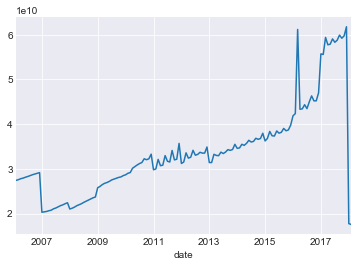

In [17]:
dfss.loc[(dfss['date'] > start) &
         (dfss['date'] < end)].groupby(pd.Grouper(key='date',freq='MS'))['salary1'].sum().plot()

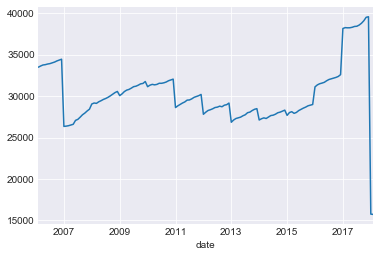

In [18]:
dfss.loc[(dfss['date'] > start) &
         (dfss['date'] < end)].groupby(pd.Grouper(key='date',freq='MS'))['person'].nunique().plot()

In [ ]:
dfss.loc[dfss['date'] < datetime(2012,1,1), ['entity', 'date', 'person', 'salary1']].sort_values(['date', 'salary1'])

In [ ]:
fig,ax = plt.subplots(figsize=(9,6))
dfss.loc[dfss['person'].str.contains('sergio ricardo trigo', na=False)].plot(x='date', y='salary1', ax=ax)
ax.set_ylim(0)
ax.set_xlim(datetime(2009,1,1))


# Check people on March 31st 2018 

In [ ]:
dfss.loc[dfss['date'] == datetime(2018,3,1), 'end_date'].value_counts()

In [ ]:
dfss.loc[(dfss['date'] == datetime(2018,3,1)) &
         (dfss['end_date'] == '30/11/-1')]

# Datets is null 

They are null because they were generated by the expanding algorithm

In [ ]:
dfss.loc[pd.isnull(dfss['datets'])].shape

# Export 

In [19]:
dfss.to_csv('../data/output/04_scraped_data_clean_scaleup_{}.csv'.format(period), 
                 sep='|', encoding='utf-8', index=False)